In [1]:
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
from datetime import datetime, timedelta
from tensorflow.keras.utils import plot_model
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from functools import reduce
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
import pickle

import warnings
warnings.filterwarnings('ignore') # 경고 메세지 OFF


2024-02-19 23:53:09.623794: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-19 23:53:09.729605: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-19 23:53:09.757397: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-19 23:53:10.253089: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

#### 데이터 준비

In [2]:
df = pd.read_csv('/home/user/exercise_j/GPT Project/CoinMarketCapAPI/CMC_final.csv')

In [3]:
df['date'] = pd.to_datetime(df['date'])
df.sort_values(by='date', ascending=True, inplace=True)
df.reset_index(drop=True, inplace=True)
df.head()

,text_content,date,ticker,sentiment_score
0,"$DOT Polkadot (DOT) Price Prediction 2023, 20...",2023-05-29,DOT,0.8
1,$KASTA ❓ Did you know that one of #Polkadot ...,2023-05-29,DOT,0.8
2,HopefulofNFTs BullishAF on $DOT,2023-05-30,DOT,0.9
3,‼️⚠️ Hongkong is opening crypto trading June ...,2023-05-30,BTC,0.8
4,$DOT It's just a slight decline and it's just...,2023-05-30,DOT,0.3


#### (가장 데이터가 많이 존재하는)최근 6개월의 데이터로 input_data 설정
##### 2023.06.01 ~ 2023.12.31

In [4]:
start_date = '2023-06-01'
end_date = '2023-12-31'
filtered_df = df[(df['date'] >= start_date) & (df['date'] <= end_date)]
filtered_df.reset_index(drop=True, inplace=True)
filtered_df['date'] = pd.to_datetime(filtered_df['date'])
filtered_df

,text_content,date,ticker,sentiment_score
0,$DOT half way to 1k DOT. Please keep dropping.,2023-06-01,DOT,-0.10
1,😎 Are you a $DOT fan? \n\n📲 We just introduced...,2023-06-01,DOT,0.80
2,$DOT I am bull with fot..,2023-06-01,DOT,0.60
3,$DOT Analyst: Bulls pushed Polkadot above the...,2023-06-01,DOT,-0.70
4,$DOT and $KSM lets go 🙌🙌🙌🐂🐂🐂,2023-06-01,DOT,1.00
...,...,...,...,...
45354,"How to HACK Binance: Turning $1,800 into $568K...",2023-12-31,SOL,0.80
45355,$SOL and TET @ $20 now. 10 million supply. Fas...,2023-12-31,SOL,0.80
45356,$SOL coreection done .. way to go 🚀🚀🚀🚀,2023-12-31,SOL,0.90
45357,Sundays often present us with positive movemen...,2023-12-31,SOL,0.75


1. 티커별로 분류
2. 각 티커별로 input_data 생성
 - input_data의 구성은 created_at sentiment_score

In [5]:
# 1. 티커별로 데이터프레임을 분류
tickers = filtered_df['ticker'].unique()
ticker_dfs = {ticker: filtered_df[filtered_df['ticker'] == ticker] for ticker in tickers}

# 2. 각 티커에 대한 input_data를 생성
# input_data는 'created_at'과 'sentiment_score'만 포함
input_data = {ticker: filtered_df[['date', 'sentiment_score']] for ticker, filtered_df in ticker_dfs.items()}

input_data['ETH'] 

,date,sentiment_score
151,2023-06-28,0.0
232,2023-07-04,0.8
259,2023-07-06,0.0
281,2023-07-09,-1.0
306,2023-07-10,0.7
...,...,...
45010,2023-12-31,0.8
45046,2023-12-31,0.8
45243,2023-12-31,0.8
45307,2023-12-31,-0.8


In [6]:
grouped_input_data = {}
for ticker, df in ticker_dfs.items():
    grouped_df = df.groupby('date')['sentiment_score'].sum().reset_index()
    grouped_input_data[ticker] = grouped_df

grouped_input_data

{'DOT':           date  sentiment_score
 0   2023-06-01             1.60
 1   2023-06-02             0.80
 2   2023-06-03            -0.85
 3   2023-06-04             3.20
 4   2023-06-05             5.20
 ..         ...              ...
 203 2023-12-27             2.40
 204 2023-12-28             8.00
 205 2023-12-29             7.40
 206 2023-12-30             3.05
 207 2023-12-31             3.90
 
 [208 rows x 2 columns],
 'BNB':           date  sentiment_score
 0   2023-06-03             0.00
 1   2023-06-16             0.80
 2   2023-06-26             0.70
 3   2023-07-21             1.60
 4   2023-07-23             1.60
 ..         ...              ...
 127 2023-12-27            38.40
 128 2023-12-28            47.90
 129 2023-12-29            27.60
 130 2023-12-30            15.65
 131 2023-12-31             4.10
 
 [132 rows x 2 columns],
 'BTC':           date  sentiment_score
 0   2023-06-03             0.00
 1   2023-06-04            -1.00
 2   2023-06-07             0.00
 

#### 각 크립토 거래 종가, 거래 규모 데이터 (2023.06.01 ~ 2023.12.31)

In [7]:
BTC = pd.read_csv("/home/user/exercise_j/GPT Project/LSTM/비트코인 과거 데이터.csv")
ETH = pd.read_csv("/home/user/exercise_j/GPT Project/LSTM/이더리움 과거 데이터.csv")
BNB = pd.read_csv("/home/user/exercise_j/GPT Project/LSTM/BNB 과거 데이터.csv")
DOT = pd.read_csv("/home/user/exercise_j/GPT Project/LSTM/Polkadot 과거 데이터.csv")
SOL = pd.read_csv("/home/user/exercise_j/GPT Project/LSTM/Solana 과거 데이터.csv")
FTT = pd.read_csv("/home/user/exercise_j/GPT Project/LSTM/FTX Token 과거 데이터.csv")
XRP = pd.read_csv("/home/user/exercise_j/GPT Project/LSTM/XRP 과거 데이터.csv")
UNI = pd.read_csv("/home/user/exercise_j/GPT Project/LSTM/Uniswap 과거 데이터.csv")

In [8]:
# 날짜 범위 정의
start_date = pd.to_datetime('2023-01-01')
end_date = pd.to_datetime('2023-12-31')

# 데이터프레임과 티커 이름을 매핑
ticker_dfs = {'BTC':BTC, 'ETH': ETH, 'BNB': BNB, 'DOT': DOT, 'SOL': SOL, 'FTT': FTT, 'XRP':XRP,'UNI':UNI}

# 각 데이터프레임을 처리하고 결과를 저장
filtered_dfs = {}
for ticker, df in ticker_dfs.items():
    # 필요없는 열 삭제
    del df['변동 %']
    del df['고가']
    del df['시가']
    del df['저가']
    
    # 날짜 열을 datetime 객체로 변환
    df['date'] = pd.to_datetime(df['날짜'])
    del df['날짜']

    # 주어진 날짜 범위에 맞게 필터링
    filtered_df2 = df[(df['date'] >= start_date) & (df['date'] <= end_date)]
    filtered_df2.reset_index(drop=True, inplace=True)

    # 필터링된 데이터프레임을 딕셔너리에 저장
    filtered_dfs[ticker] = filtered_df2


In [9]:
filtered_dfs['ETH']

,종가,거래량,date
0,"2,281.90",232.62K,2023-12-31
1,"2,291.70",219.92K,2023-12-30
2,"2,299.24",475.37K,2023-12-29
3,"2,344.47",626.91K,2023-12-28
4,"2,378.63",577.27K,2023-12-27
...,...,...,...
360,"1,250.95",289.49K,2023-01-05
361,"1,256.92",504.28K,2023-01-04
362,"1,214.57",219.98K,2023-01-03
363,"1,213.93",270.72K,2023-01-02


#### (${p_t}, {v_t}, {s_t}$) 만들기

In [10]:
print(grouped_input_data.keys())
print(filtered_dfs.keys())

dict_keys(['DOT', 'BNB', 'BTC', 'XRP', 'SOL', 'UNI', 'ETH', 'FTT'])
dict_keys(['BTC', 'ETH', 'BNB', 'DOT', 'SOL', 'FTT', 'XRP', 'UNI'])


In [11]:
def convert_volume(volume):
    if isinstance(volume, str):  # volume이 문자열인지 확인
        if 'K' in volume:
            return float(volume.replace('K', '')) * 1000
        elif 'M' in volume:
            return float(volume.replace('M', '')) * 1000000
        elif 'B' in volume:
            return float(volume.replace('B', '')) * 1000000000
        else:
            return float(volume)
    else:
        return volume

In [12]:
merged_dfs = {}
for ticker in ['BTC', 'ETH', 'BNB', 'DOT', 'SOL', 'FTT', 'XRP','UNI']:
    merged_df = pd.merge(filtered_dfs[ticker], grouped_input_data[ticker], on='date', how='outer')
    merged_df['sentiment_score'] = merged_df['sentiment_score'].fillna(0.0)
    merged_df['거래량'] = merged_df['거래량'].apply(convert_volume)
    merged_dfs[ticker] = merged_df

# 결과 출력
merged_dfs

{'BTC':            종가       거래량       date  sentiment_score
 0    42,272.5   35580.0 2023-12-31           225.45
 1    42,136.7   35180.0 2023-12-30           264.15
 2    42,072.4   60980.0 2023-12-29           351.55
 3    42,581.1   49840.0 2023-12-28           264.40
 4    43,446.5   50100.0 2023-12-27           269.61
 ..        ...       ...        ...              ...
 360  16,829.8  178960.0 2023-01-05             0.00
 361  16,852.1  247390.0 2023-01-04             0.00
 362  16,674.2  178730.0 2023-01-03             0.00
 363  16,674.3  136030.0 2023-01-02             0.00
 364  16,618.4  107840.0 2023-01-01             0.00
 
 [365 rows x 4 columns],
 'ETH':            종가       거래량       date  sentiment_score
 0    2,281.90  232620.0 2023-12-31            19.10
 1    2,291.70  219920.0 2023-12-30            28.65
 2    2,299.24  475370.0 2023-12-29            34.40
 3    2,344.47  626910.0 2023-12-28            70.05
 4    2,378.63  577270.0 2023-12-27            50.75
 ..  

#### 각 티커별 데이터 변환 및 스케일링

#### MinMax scaler

processed_data2 = {}
scaler = MinMaxScaler()
for ticker, df in merged_dfs.items():
    # '종가' 열 처리: 쉼표 제거, 실수형 변환
    prices = df['종가'].replace(',', '', regex=True).astype(float).values.reshape(-1, 1)

    # '거래량' 열 처리
    volumes = df['거래량'].values.reshape(-1, 1)

    # 'sentiment_score' 열 처리
    sentiments = df['sentiment_score'].values.reshape(-1, 1)

    # (p_t, v_t, s_t) 형태로 결합
    data = np.hstack((prices, volumes, sentiments))
    # 데이터를 표준화
    data = scaler.fit_transform(data)
    
    processed_data2[ticker] = data

data2 = processed_data2['BNB']

In [13]:
processed_data = {}

for ticker, df in merged_dfs.items():
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)
    
    # '종가' 열이 문자열이라면 쉼표 제거 후 로그 변환을 수행
    if df['종가'].dtype == 'O':  # 'O'는 객체(object) 타입을 의미합니다.
        prices = df['종가'].str.replace(',', '').astype(float)
    else:
        prices = df['종가'].astype(float)
    prices_log = np.log1p(prices)

    sentiments = df['sentiment_score']
    volumes_log = np.log1p(df['거래량'].astype(float))

    features = np.stack((prices_log, volumes_log, sentiments), axis=1)
    processed_data[ticker] = features

In [14]:
processed_data

{'BTC': array([[ 10.65191569,  10.47956707, 225.45      ],
        [ 10.64869811,  10.46826144, 264.15      ],
        [ 10.64717099,  11.01831762, 351.55      ],
        ...,
        [  9.72167786,  12.09363716,   0.        ],
        [  9.72168386,  11.82063808,   0.        ],
        [  9.71832597,  11.5884132 ,   0.        ]]),
 'ETH': array([[ 7.73320184, 12.3571658 , 19.1       ],
        [ 7.73748544, 12.30102367, 28.65      ],
        [ 7.74076874, 13.07185083, 34.4       ],
        ...,
        [ 7.10296838, 12.30129646,  0.        ],
        [ 7.10244174, 12.50884405,  0.        ],
        [ 7.0913427 , 11.74895365,  0.        ]]),
 'BNB': array([[ 5.74620319, 13.42624011,  4.1       ],
        [ 5.76079273, 13.25514624, 15.65      ],
        [ 5.75130199, 14.1731857 , 27.6       ],
        ...,
        [ 5.51019773, 11.65988751,  0.        ],
        [ 5.50614421, 12.06888314,  0.        ],
        [ 5.50288953, 11.60869917,  0.        ]]),
 'DOT': array([[ 2.21963817, 16.45

#### 데이터셋 생성
##### time_steps = 7일

In [15]:
def create_dataset_with_updated_Q(data, start_index, end_index, time_steps=30):
    dataX, dataY, dataZ = [], [], []
    # 첫 번째 예상 수익률 Q_t-1을 0으로 초기화

    for i in range(start_index, end_index):
        # 현재 time_steps 만큼의 데이터
        a = data[(i - time_steps):i, :]
        # 다음 시점의 가격을 통해 Q_t를 계산
        current_price = data[i, 0]
        prior_price = data[i - 1, 0]
        Q_t = (current_price - prior_price) / prior_price
        # a에 최신 Q_t_minus_1 추가
        sentiment = data[i, 2]

        dataX.append(a)
        dataY.append(Q_t)
        dataZ.append(sentiment)
        # 다음 루프를 위해 Q_t-1 업데이트

    return np.array(dataX), np.array(dataY), np.array(dataZ)

# 데이터셋 준비
time_steps = 30
start_index = 151
end_index = 365

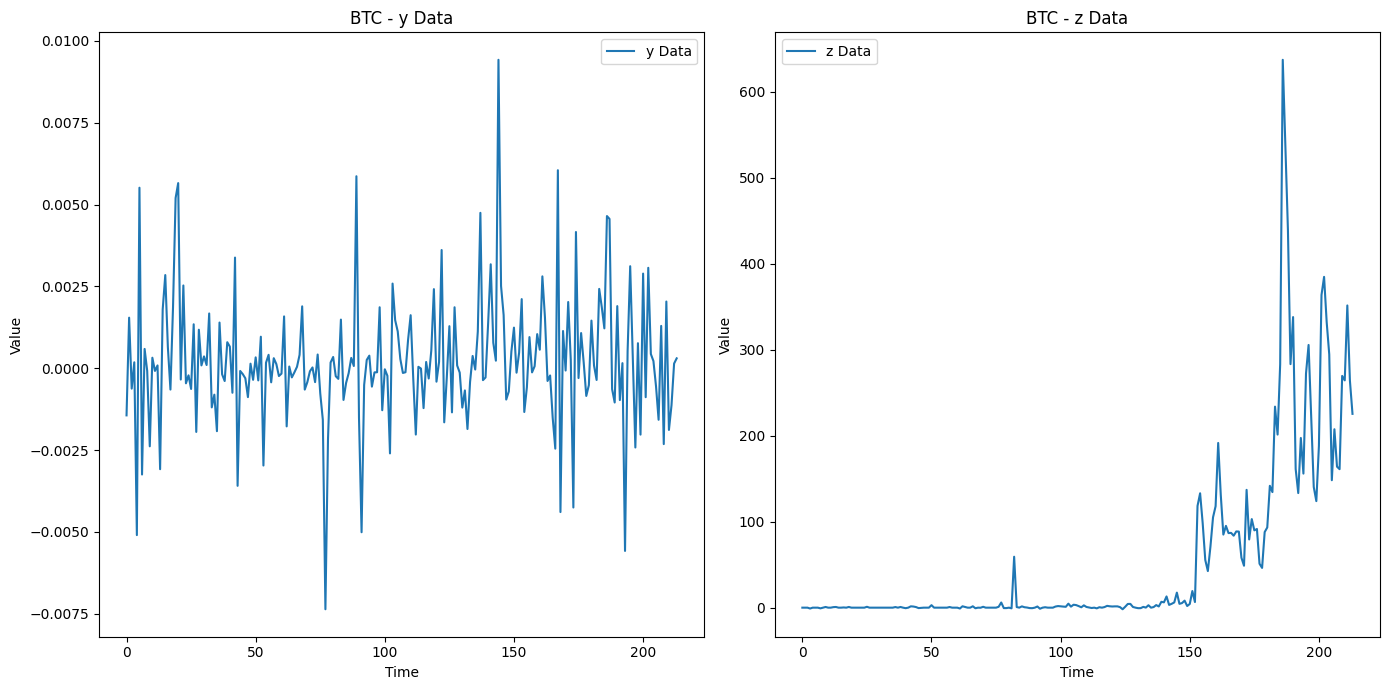

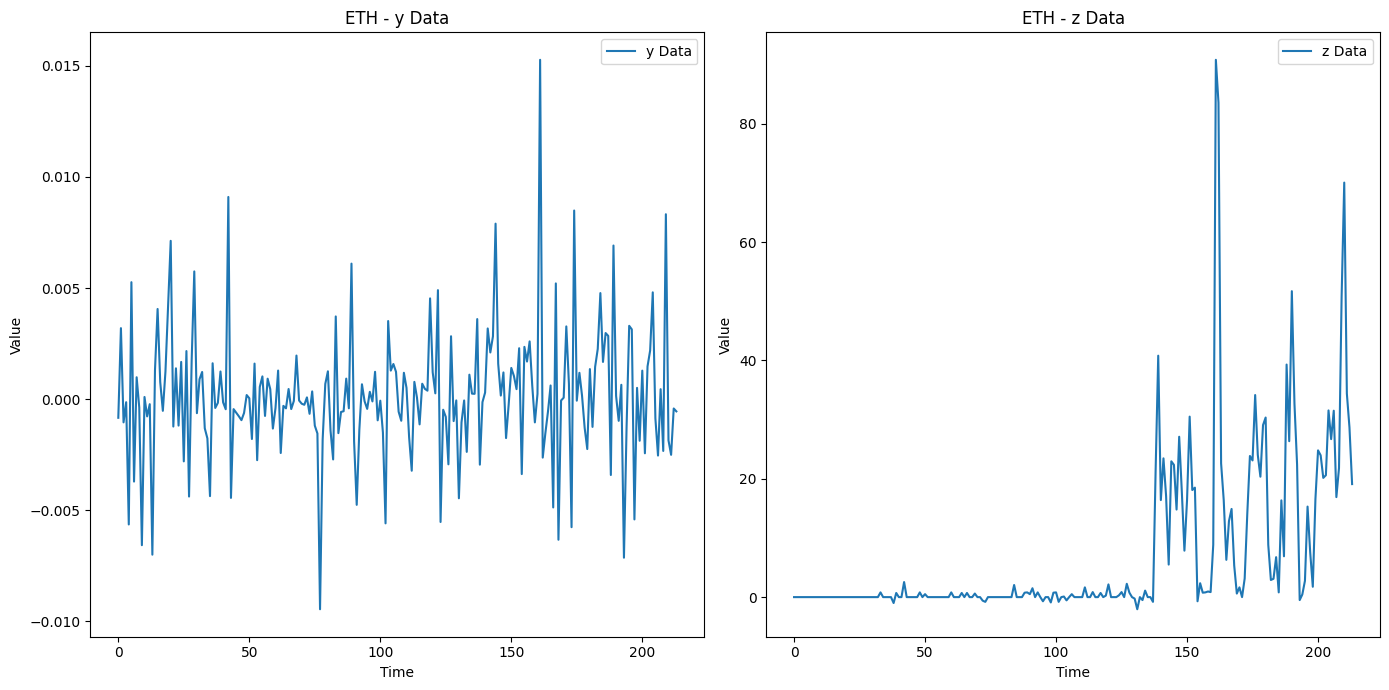

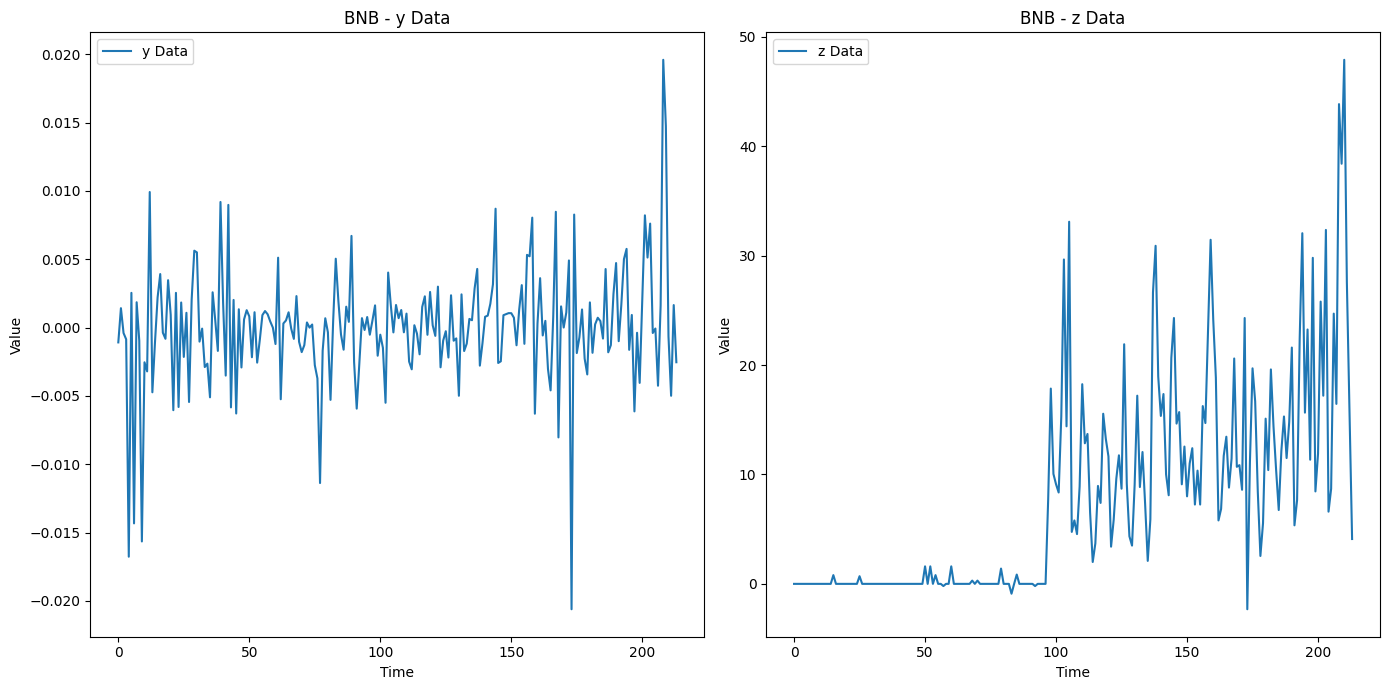

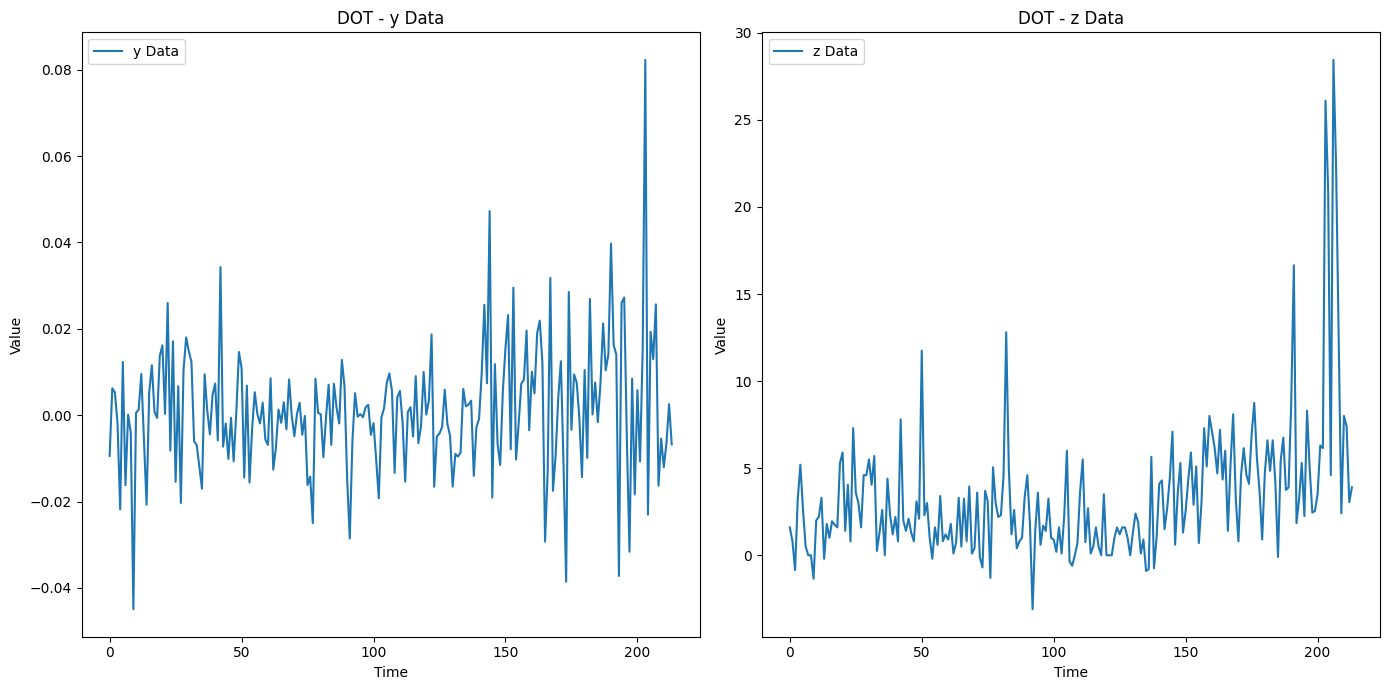

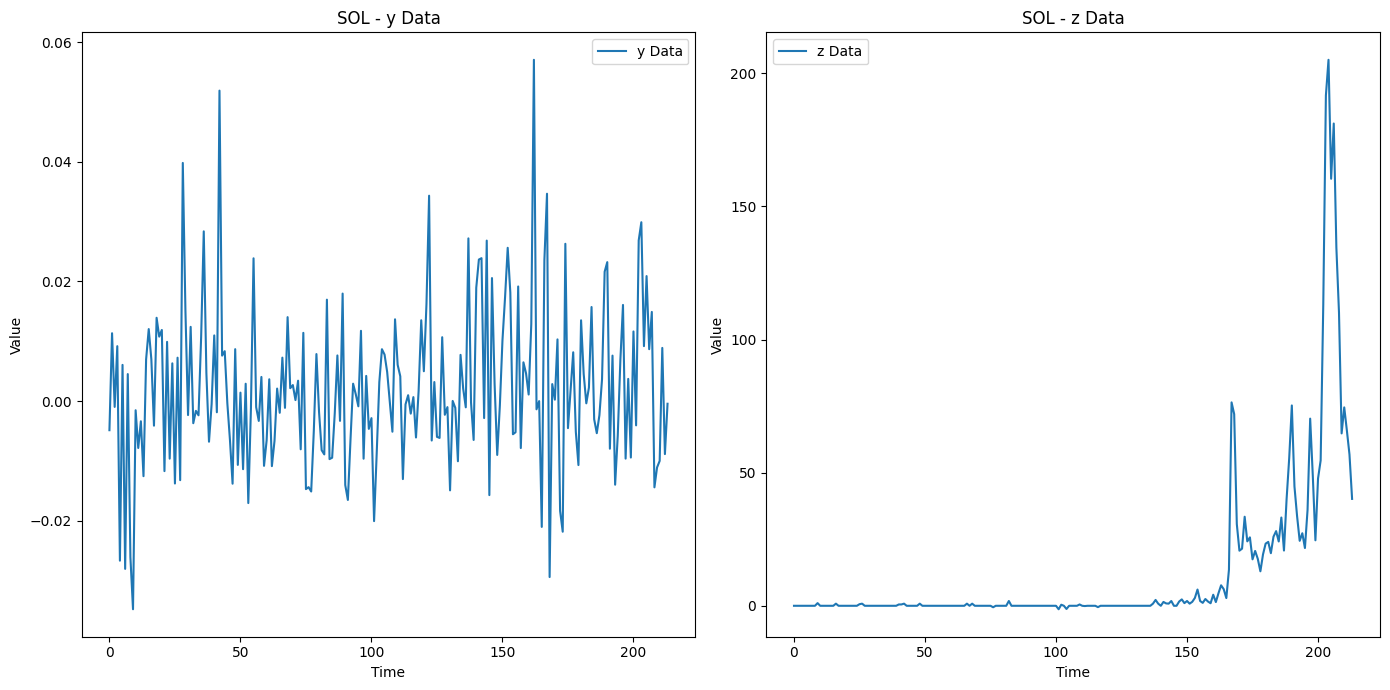

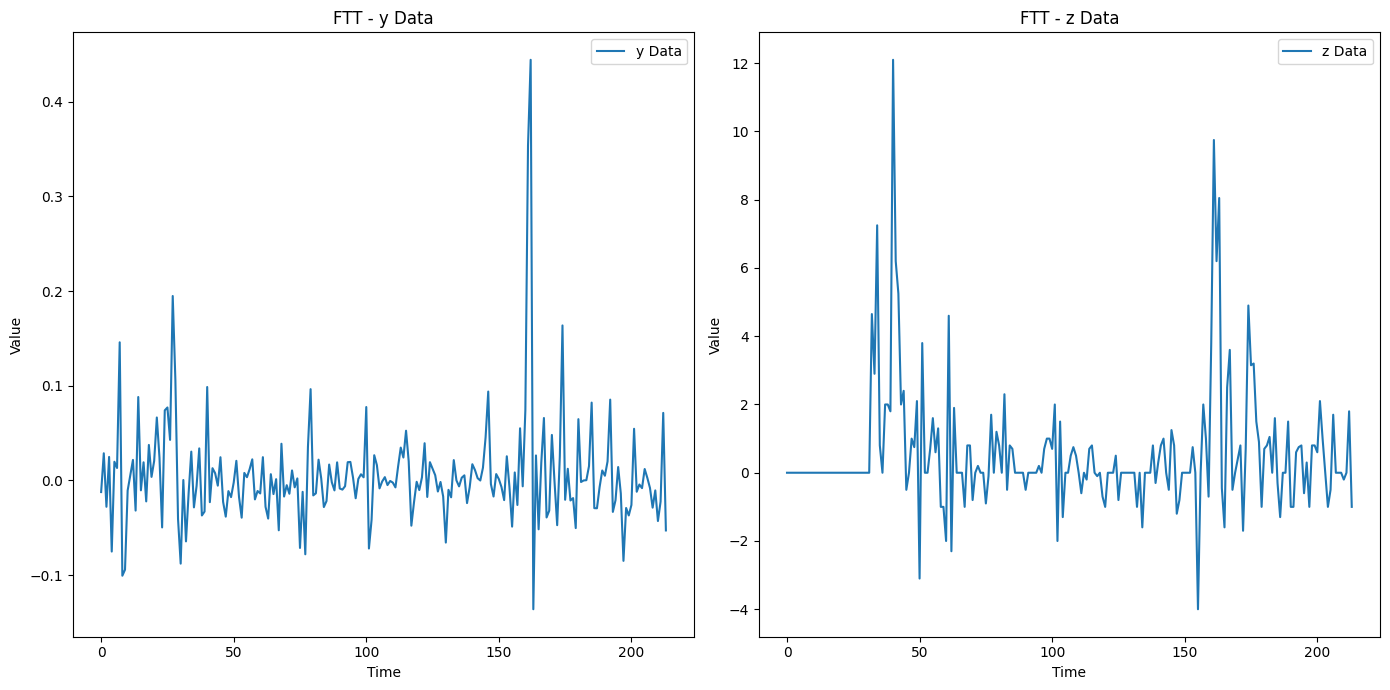

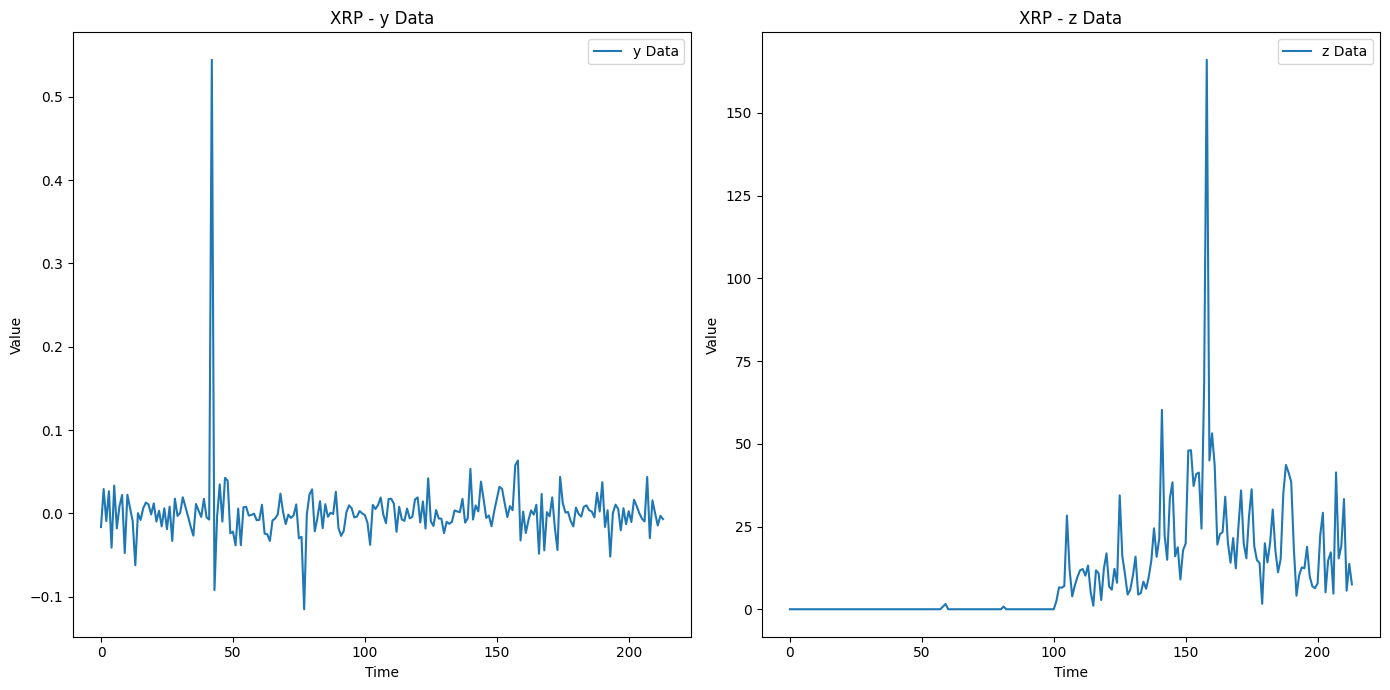

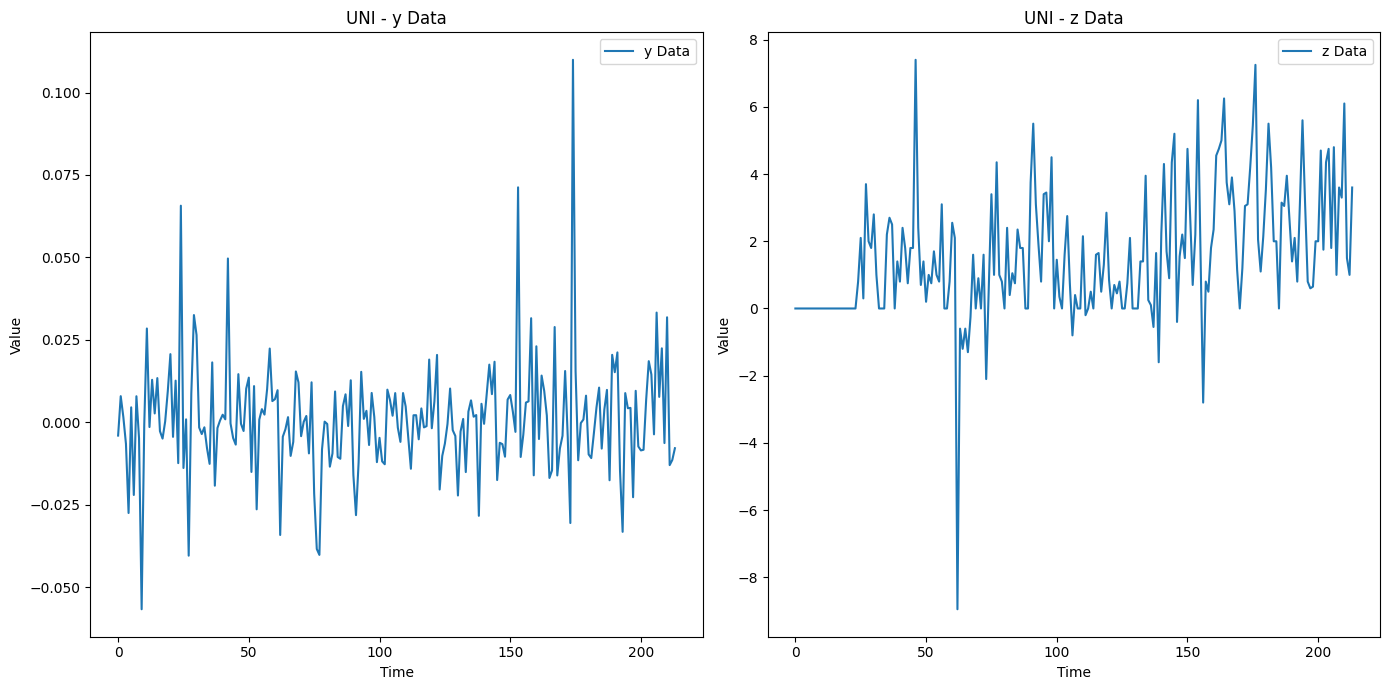

In [16]:
import matplotlib.pyplot as plt

def plot_data(ticker, y, z):
    plt.figure(figsize=(14, 7))
    
    # y 데이터 그래프
    plt.subplot(1, 2, 1)
    plt.plot(y, label='y Data')
    plt.title(f'{ticker} - y Data')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()

    # z 데이터 그래프
    plt.subplot(1, 2, 2)
    plt.plot(z, label='z Data')
    plt.title(f'{ticker} - z Data')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

results = {}
for ticker, data in processed_data.items():
    data = np.flipud(data)
    # 입력 데이터셋 생성
    X, y, z = create_dataset_with_updated_Q(data, start_index, end_index, time_steps)
    results[ticker] = {'y': y, 'z': z}
    plot_data(ticker, y, z)  # 각 티커별로 그래프를 그림

#### LSTM 함수 정의

In [16]:
# 예측 수행 함수
def lstm_predict(X, model):
    predicted_returns = []
    for i in tqdm(range(len(X)), desc="Predicting"):
        # 모델을 사용하여 예측
        predicted_return = model.predict(np.expand_dims(X[i], axis=0), verbose=0)
        predicted_returns.append(predicted_return[0,0])
    return predicted_returns


#### LSTM 완성
##### 결과 비교
예시 : ETH

In [17]:
data = processed_data['BTC']
data = np.flipud(data)

data

array([[  9.71832597,  11.5884132 ,   0.        ],
       [  9.72168386,  11.82063808,   0.        ],
       [  9.72167786,  12.09363716,   0.        ],
       ...,
       [ 10.64717099,  11.01831762, 351.55      ],
       [ 10.64869811,  10.46826144, 264.15      ],
       [ 10.65191569,  10.47956707, 225.45      ]])

In [18]:
X, y = create_dataset_with_updated_Q(data, start_index, end_index, time_steps)

# 모델 정의
model = Sequential()

# 첫 번째 LSTM 층 추가. return_sequences=True는 다음 층이 LSTM 층일 때 필요
model.add(LSTM(2000, return_sequences=False, input_shape=(X.shape[1], X.shape[2])))

# Dropout을 추가하여 과적합 방지
# model.add(Dropout(0.2))

# 두 번째 LSTM 층 추가
# model.add(LSTM(1000, return_sequences=True))

# model.add(LSTM(50, return_sequences=True))

# model.add(LSTM(100, return_sequences=True))

# 또 다른 Dropout 층
# model.add(Dropout(0.2))

# 세 번째 LSTM 층 추가
# model.add(LSTM(1000))

# 마지막 Dense 층 추가. 출력층
model.add(Dense(1))

# 모델 컴파일
model.compile(optimizer='adam', loss='mean_squared_error')

# 모델 학습
model.fit(X, y, epochs=500, batch_size=32, verbose=1)

predicted_returns = lstm_predict(X, model)


2024-02-12 22:35:16.731303: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-12 22:35:17.572834: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22288 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:1a:00.0, compute capability: 8.6
2024-02-12 22:35:17.573478: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22286 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:68:00.0, compute capability: 8.6


Epoch 1/500


2024-02-12 22:35:25.705699: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2024-02-12 22:35:26.340878: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


7/7 [==============================] - 3s 14ms/step - loss: 23.7428
Epoch 2/500
7/7 [==============================] - 0s 14ms/step - loss: 0.2933
Epoch 3/500
7/7 [==============================] - 0s 14ms/step - loss: 0.1964
Epoch 4/500
7/7 [==============================] - 0s 13ms/step - loss: 0.0821
Epoch 5/500
7/7 [==============================] - 0s 14ms/step - loss: 0.0309
Epoch 6/500
7/7 [==============================] - 0s 14ms/step - loss: 0.0260
Epoch 7/500
7/7 [==============================] - 0s 14ms/step - loss: 0.0111
Epoch 8/500
7/7 [==============================] - 0s 14ms/step - loss: 0.0096
Epoch 9/500
7/7 [==============================] - 0s 14ms/step - loss: 0.0074
Epoch 10/500
7/7 [==============================] - 0s 15ms/step - loss: 0.0066
Epoch 11/500
7/7 [==============================] - 0s 12ms/step - loss: 0.0059
Epoch 12/500
7/7 [==============================] - 0s 13ms/step - loss: 0.0053
Epoch 13/500
7/7 [==============================] - 0s 14ms/

Predicting: 100%|██████████| 214/214 [00:12<00:00, 17.81it/s]


#### 그래프 생성

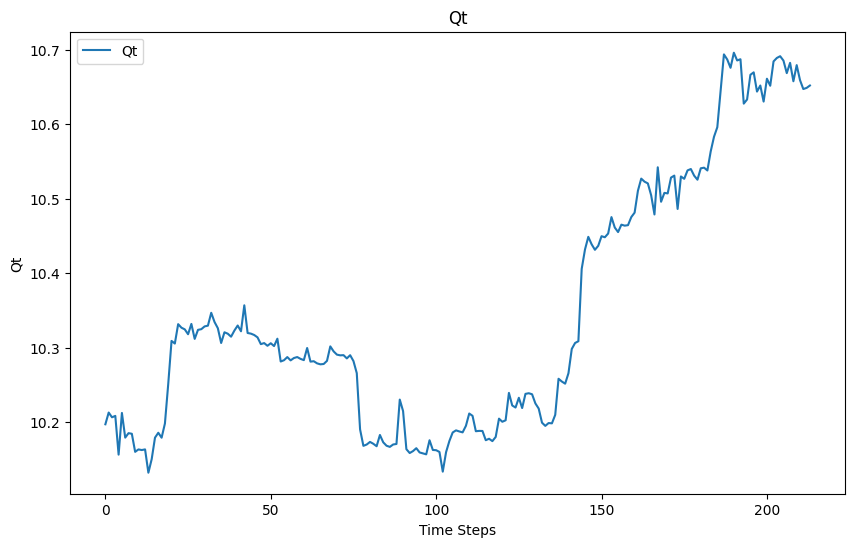

In [19]:
plt.figure(figsize=(10, 6))
plt.plot(y, label='Qt')
plt.xlabel('Time Steps')
plt.ylabel('Qt')
plt.title('Qt')
plt.legend()
plt.show()

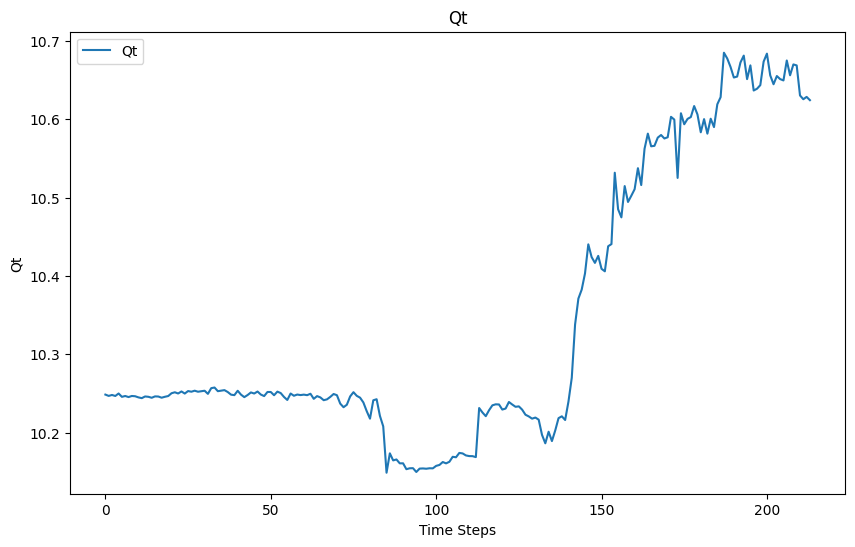

In [20]:
plt.figure(figsize=(10, 6))
plt.plot(predicted_returns, label='Qt')
plt.xlabel('Time Steps')
plt.ylabel('Qt')
plt.title('Qt')
plt.legend()
plt.show()

In [21]:
results = {}
for ticker, data in processed_data.items():
    data = np.flipud(data)
    # 입력 데이터셋 생성
    X, y = create_dataset_with_updated_Q(data, start_index, end_index, time_steps)
    # 모델 정의
    model = Sequential()

    # 첫 번째 LSTM 층 추가. return_sequences=True는 다음 층이 LSTM 층일 때 필요
    model.add(LSTM(1000, return_sequences=False, input_shape=(X.shape[1], X.shape[2])))

    # Dropout을 추가하여 과적합 방지
    # model.add(Dropout(0.2))

    # 두 번째 LSTM 층 추가
    # model.add(LSTM(1000, return_sequences=True))

    # 또 다른 Dropout 층
    # model.add(Dropout(0.2))

    # 세 번째 LSTM 층 추가
    # model.add(LSTM(1000))

    # 마지막 Dense 층 추가. 출력층
    model.add(Dense(1))

    # 모델 컴파일
    model.compile(optimizer='adam', loss='mean_squared_error')

    # 모델 학습
    model.fit(X, y, epochs=200, batch_size=32, verbose=0)

    predicted_returns = lstm_predict(X, model)
    results[ticker] = {
        'predicted_returns': predicted_returns
    }
    

Predicting: 100%|██████████| 214/214 [00:13<00:00, 16.28it/s]


#### Verification을 위해 predicted returns 분리 후 pickle로 같은 디렉토리에 저장

In [22]:
# 각 티커별 predicted returns를 저장할 딕셔너리
predicted_returns_by_ticker = {}

for ticker, result in results.items():
    predicted_returns_by_ticker[ticker] = result['predicted_returns']

# 결과 출력
for ticker, predicted_returns in predicted_returns_by_ticker.items():
    print(f"Ticker: {ticker}")
    print("Predicted Returns:", predicted_returns)
    print()

Ticker: BTC
Predicted Returns: [10.252285, 10.252207, 10.251546, 10.247274, 10.239696, 10.243975, 10.252417, 10.253454, 10.24715, 10.244048, 10.253213, 10.253502, 10.249438, 10.253494, 10.258774, 10.2585335, 10.255796, 10.252825, 10.249037, 10.253185, 10.25968, 10.262048, 10.260605, 10.259645, 10.255508, 10.25228, 10.25861, 10.260794, 10.256616, 10.255425, 10.258437, 10.25263, 10.247281, 10.253815, 10.253701, 10.252513, 10.254391, 10.259482, 10.253943, 10.249684, 10.256121, 10.252644, 10.250717, 10.262349, 10.273476, 10.265556, 10.252809, 10.251039, 10.251127, 10.252489, 10.253294, 10.264994, 10.264553, 10.2535095, 10.255794, 10.250972, 10.252217, 10.25119, 10.253574, 10.24995, 10.245301, 10.247772, 10.247416, 10.255806, 10.263878, 10.257626, 10.247198, 10.252352, 10.252205, 10.251848, 10.255991, 10.258514, 10.254201, 10.243704, 10.239489, 10.246923, 10.249477, 10.254827, 10.287862, 10.291325, 10.253295, 10.252406, 10.248636, 10.172871, 10.176289, 10.21895, 10.201076, 10.192989, 10.177

In [23]:
with open('/home/user/exercise_j/GPT Project/Sentiment-Portfolio-Asset-allocation/CMCAPI/q_vector_epoch_price_log.pkl', 'wb') as f:
    pickle.dump(predicted_returns_by_ticker, f)